## auto arima

자동으로 sarima 분석을 수행할 수 있다.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('../data/arima_data.csv', names = ['day', 'price'])
data['day'] = pd.to_datetime(data['day'],format="%Y-%m-%d")
data.set_index('day', inplace=True)
s_data = data


In [2]:
#!pip install pmdarima
#!conda install pmdarima -y 

In [3]:
train_len = int(len(s_data)*0.8)
training = s_data[:train_len]
test = s_data.drop(training.index)

In [6]:
from pmdarima import auto_arima

auto_model = auto_arima(training, start_P=1, D=1 , Q=1,
                        max_P=5, max_D=5, max_Q=5, m=12,
                        seasonal=True, information_criterion='aic',
                        trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=500.898, Time=0.77 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=513.245, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=496.519, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=500.500, Time=0.42 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=569.050, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=495.874, Time=0.22 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=496.035, Time=0.39 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=498.479, Time=0.14 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=497.831, Time=0.19 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=497.839, Time=0.17 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=501.105, Time=0.06 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=499.873, Time=0.17 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=510.570, Time=0.06 sec

Best model:  ARIMA(1,0,0)(0,1,0)[12] intercept
Total fit time: 2.771 seconds


In [8]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -244.937
Date:                            Fri, 10 Dec 2021   AIC                            495.874
Time:                                    06:27:40   BIC                            500.625
Sample:                                         0   HQIC                           497.532
                                             - 48                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    239.6144     71.575      3.348      0.001      99.331     379.898
ar.L1          0.5607      0.093      6.009      0.000       0.378       0.744
sigma2      4.342e+04   1.27e+04      3.411      0.001    1.85e+04    6.84e+04
===================================================================================
Ljung-Box (Q):                       27.66   Jarque-Bera (JB):                 1.08
Prob(Q):                              0.81   Prob(JB):                         0.58
Heteroskedasticity (H):               1.05   Skew:                            -0.09
Prob(H) (two-sided):                  0.93   Kurtosis:                         2.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

각 요소의 P-value와  AIC 확인

In [9]:
# 학습 데이터셋으로부터 test 데이터 길이만큼 예측
prediction= pd.DataFrame(auto_model.predict(n_periods=len(test)), 
                          index=test.index) 
prediction

,0
day,
2017-01-01,5654.661643
2017-02-01,5762.178918
2017-03-01,7201.238739
2017-04-01,8260.255501
2017-05-01,8795.415504
2017-06-01,9402.019844
2017-07-01,10306.555324
2017-08-01,8723.173539
2017-09-01,8013.398812


In [10]:
prediction.columns = ['predicted_price']
prediction

,predicted_price
day,
2017-01-01,5654.661643
2017-02-01,5762.178918
2017-03-01,7201.238739
2017-04-01,8260.255501
2017-05-01,8795.415504
2017-06-01,9402.019844
2017-07-01,10306.555324
2017-08-01,8723.173539
2017-09-01,8013.398812


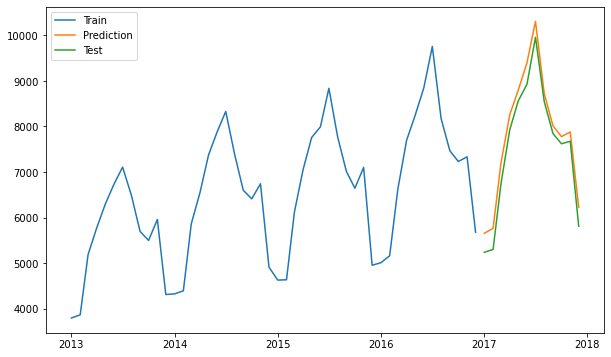

In [11]:
plt.figure(figsize=(10,6))
plt.plot(training, label="Train") # Train 데이터 
plt.plot(prediction, label="Prediction") # 모델이 예상한 그래프 
plt.plot(test, label="Test") # 실제 가격 그래프 

plt.legend(loc='upper left')
plt.show()

In [12]:
from sklearn.metrics import r2_score,mean_squared_error
test['predicted_price'] = prediction
r2_score(test['price'], test['predicted_price'])

0.9415943476073537

In [13]:
import numpy as np
import math
rmse = np.sqrt(mean_squared_error(test['price'], test['predicted_price']))
rmse 

342.23949855666933

In [14]:
len(test['price'])

12

### 결과 해석

* 1) 시계열 데이터 분석한 결과 1년 주기의 계절성을 가지고 있음을 확인할 수 있었다. 
* 2) 또한 우상향하는 추세가 있음을 알 수 있었다. 
* 3) 추세를 가지고 있으므로 1차 차분을 해줘야 한다. 

* 계절성을 가지고 있으므로 예측 모형은 SARIMA를 사용하였다. 
* 최적의 매개변수를 갖는 SARIMAX(1, 0, 0)x(0, 1, 0, 12) 모델의 설명력은 94.1%로 예측의 정확도가 매우 높았다. 
* 예측값과 실제값의 차이는 평균적으로 342 정도 난다고 할 수 있다.  